In [1]:
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os
import json
import sys
import sqlite3
import urllib.request, json 
import datetime

Library versions:

In [2]:
nx.__version__

'2.5'

In [3]:
pd.__version__

'1.2.3'

In [4]:
matplotlib.__version__

'3.1.1'

# Data loading

## Last.fm dataset 1K users
The main file containing information about individual listenings to music tracks of almost 1000 users in the years 2005-2009.

Link: http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html

In [5]:
listenings = pd.read_csv('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',
                         sep='\t',error_bad_lines=False, header= None,
                         names=['userid','timestamp','artid','artname','traid','traname'])

In [6]:
# convert timestamp's datatype and use it as index
listenings['timestamp'] = pd.to_datetime(listenings['timestamp'])
listenings.index = listenings['timestamp']

In [7]:
listenings.head()

,userid,timestamp,artid,artname,traid,traname
timestamp,,,,,,
2009-05-04 23:08:57+00:00,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
2009-05-04 13:54:10+00:00,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2009-05-04 13:52:04+00:00,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
2009-05-04 13:42:52+00:00,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
2009-05-04 13:42:11+00:00,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [8]:
listenings.tail()

,userid,timestamp,artid,artname,traid,traname
timestamp,,,,,,
2008-01-27 22:02:35+00:00,user_001000,2008-01-27 22:02:35+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,a490cabc-1e5c-4807-86c7-740c31a50009,Please Be Patient With Me
2008-01-27 21:56:52+00:00,user_001000,2008-01-27 21:56:52+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3e92e447-9e1f-440d-bc00-6734469880c5,Shake It Off
2008-01-27 21:52:36+00:00,user_001000,2008-01-27 21:52:36+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,93d044e6-1bbb-46a6-ac8e-283382a89e6f,Side With The Seeds
2008-01-27 21:49:12+00:00,user_001000,2008-01-27 21:49:12+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,5ac4386f-6146-4389-a762-4b43f362d2c8,Sky Blue Sky
2008-01-27 21:43:14+00:00,user_001000,2008-01-27 21:43:14+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3acc99bc-a349-420f-ad28-7095eb3533c9,Impossible Germany


## Querying of the last.fm API to get realease years of the songs 
The last.fm apikey needs to be stored in a apikey.txt file.

NOT USED:
* you would need to get the album of each song and get realease date of the albums then which would take well over 100 hours of constant querying
* not every song has an album so the data would not be perfect

In [9]:
# apiKey = pd.read_csv('apikey.txt',header=None)[0][0]

In [10]:
# uniqueTracksFromListenings = listenings[['artname','traname']].drop_duplicates()

In [11]:
# ablumIds={}

# for artname,traname in tqdm(zip(uniqueTracksFromListenings['artname'],
#                                 uniqueTracksFromListenings['traname'])
#                             ,total=len(uniqueTracksFromListenings),position=0, leave=True):
#     artnameEnc = urllib.parse.quote_plus(artname)
#     tranameEnc = urllib.parse.quote_plus(traname)
    
#     with urllib.request.urlopen(f"http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={apiKey}&artist={artnameEnc}&track={tranameEnc}&format=json") as url:
#         data = json.loads(url.read().decode())
#         try:
#             ablumIds[artname+traname] = data['track']['album']['mbid']
#         except:
#             pass

  0%|          | 448/1498727 [01:47<107:39:38,  3.87it/s]

KeyboardInterrupt: 

# Data exploration and check for possible anomailies/problems in the data

In [9]:
listenings.shape

(19098862, 6)

In [10]:
# number of null values
listenings.isnull().sum()

userid             0
timestamp          0
artid         600853
artname            0
traid        2162726
traname           12
dtype: int64

In [11]:
# drop the few rows where track name is missing - these would be useless for future analysis
listenings.dropna(subset=['traname'],inplace=True)

In [12]:
# number of distinct users
listenings['userid'].nunique()

992

In [13]:
# number of distinct songs
listenings['traname'].nunique()

1083480

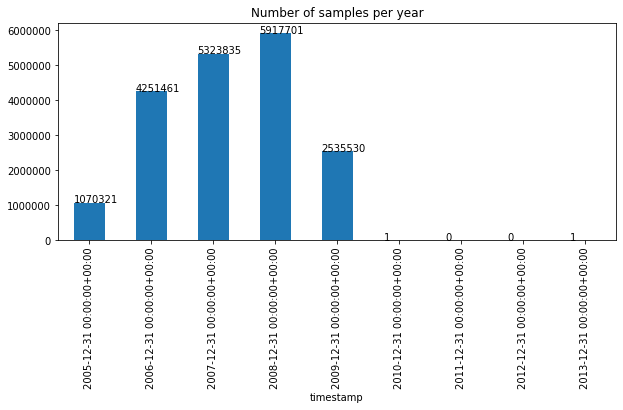

In [14]:
ax = listenings.resample('Y')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(10,4), title='Number of samples per year')

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

In [15]:
# we remove the records in 2010 and 2013 which are obviously errors
listenings = listenings[listenings['timestamp'].dt.year<2010]

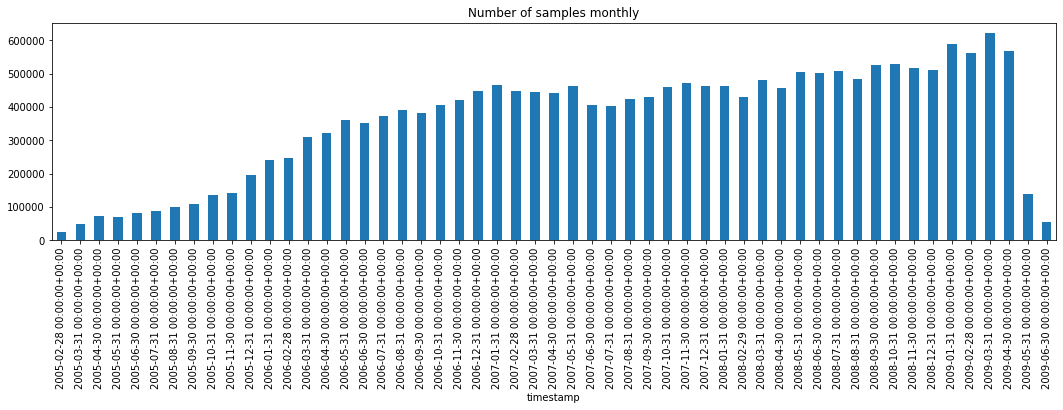

In [16]:
listenings.resample('M')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='Number of samples monthly')

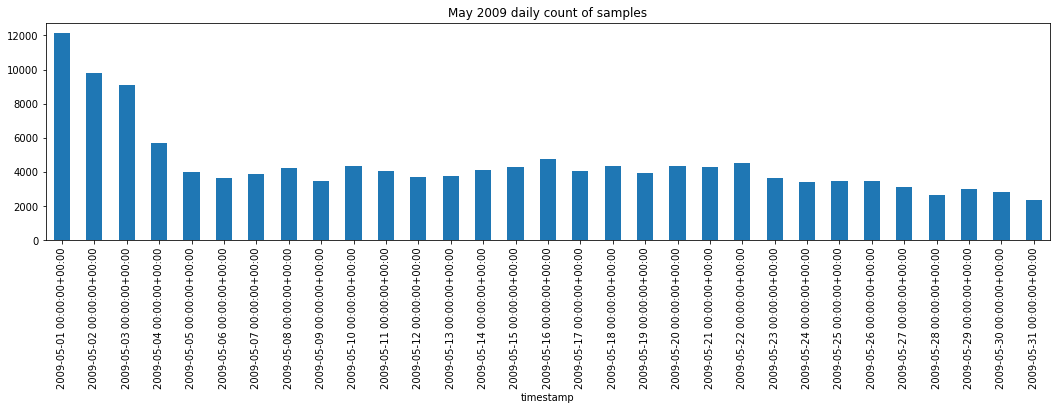

In [17]:
listenings[(listenings['timestamp'].dt.year==2009) & (listenings['timestamp'].dt.month==5)]\
    .resample('d')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='May 2009 daily count of samples')

Despite the documentation saying the latest data point in the dataset should be from May 5th the data continues a bit further. The problem is there are a lot less samples for this time period when check the monthly counts so we rather remove both May and June 2009.

In [18]:
listenings = listenings[~((listenings['timestamp'].dt.year==2009) & (listenings['timestamp'].dt.month.isin((5,6))))]

In [19]:
# number of distinct users
listenings['userid'].nunique()

991

In [20]:
# number of distinct songs
listenings['traname'].nunique()

1075618

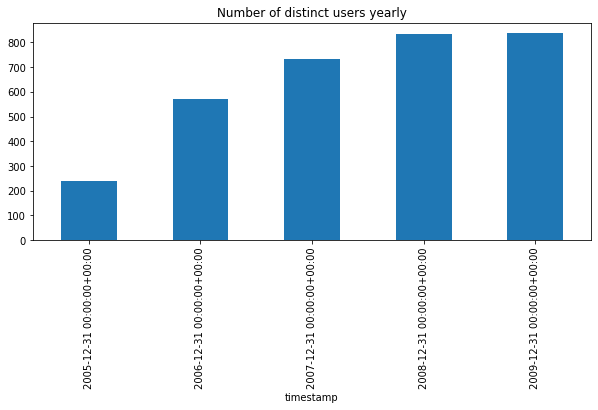

In [21]:
listenings.resample('Y').userid.nunique()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(10,4), title='Number of distinct users yearly')

We see number of users in the dataset is rising over time so we might need to take this into account when we will be analyzing the number of song listenings.

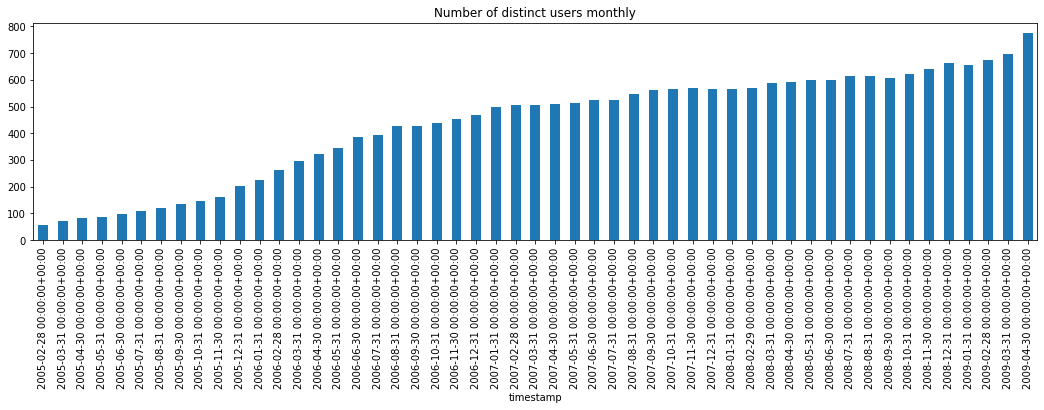

In [22]:
listenings.resample('M').userid.nunique()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='Number of distinct users monthly')

# Join with other datasets

## userid-profile.tsv
A file provided together with the listenings data containing some information about the users.

Link: http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html

In [23]:
users = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv',sep='\t')
users.rename({'#id':'userid'},axis=1,inplace=True)
users.head()

,userid,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [24]:
users.shape

(992, 5)

In [25]:
# check if id attribute is unique
users['userid'].is_unique

True

Users data can be perfectly joined to the listenings data:

In [26]:
listenings.merge(users).shape

(18904597, 10)

In [27]:
listenings.shape

(18904597, 6)

Age has too many null values, only gender and country will be usable:

In [28]:
# number of null values
users.isnull().sum()

userid          0
gender        108
age           706
country        85
registered      8
dtype: int64

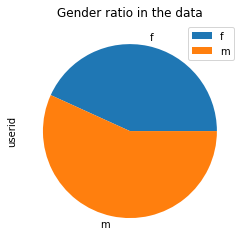

In [29]:
users.groupby('gender').count()[['userid']].plot.pie(y='userid',title='Gender ratio in the data')

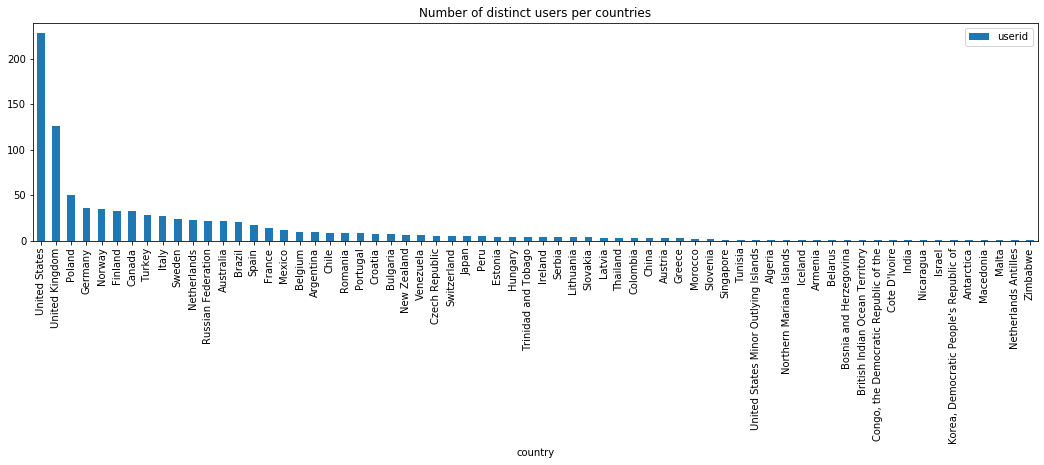

In [30]:
users.groupby('country').count()[['userid']].sort_values('userid',ascending=False)\
    .plot.bar(y='userid',figsize=(18,4),title='Number of distinct users per countries')

## Million Song Dataset - tags

A dataset conating tags(music genres) for the songs, the form of sqllite database is used. A song can have more tags - each associated with some value expressing how strongly the tag applies to the particular song. For the purpose of this analysis we will use only the tags with the highest value for each of the songs and followingly we will only consider the top 5 most common tags in the dataset so that we have reasonable number of samples in each of the tag's values (music genres).

Link: http://millionsongdataset.com/lastfm/

In [31]:
dbfile = 'lastfm_tags.db'

# open connection
conn = sqlite3.connect(dbfile)

The database contains the following 3 tables:

In [32]:
pd.read_sql_query("""select * from tags LIMIT 3;""", conn)

,tag
0,classic rock
1,Progressive rock
2,blues


In [33]:
pd.read_sql_query("""select * from tids LIMIT 3;""", conn)

,tid
0,TRCCCYE12903CFF0E9
1,TRCCCFH12903CEBC70
2,TRCCCJT128F429FFF6


In [34]:
pd.read_sql_query("""select * from tid_tag LIMIT 3;""", conn)

,tid,tag,val
0,1,1,100.0
1,1,2,100.0
2,2,3,100.0


In [35]:
# we check what the most common tags are
tags = pd.read_sql_query("""SELECT tags.tag, COUNT(tid_tag.tid) 
                        FROM tid_tag, tags 
                        WHERE tid_tag.tag=tags.ROWID 
                        GROUP BY tags.tag;""", conn)
topTags = tags.sort_values('COUNT(tid_tag.tid)',ascending=False)[:10]
topTags

,tag,COUNT(tid_tag.tid)
419585,rock,101071
397948,pop,69159
153075,alternative,55777
299442,indie,48175
233524,electronic,46270
248252,female vocalists,42565
245839,favorites,39921
80295,Love,34901
211486,dance,33618
919,00s,31432


In [36]:
# we will only use the top 5
topTagsStr = str(tuple(topTags['tag'][:5]))

In [37]:
# get the tags with values for each of the track ids
trackGenres = pd.read_sql_query(f"""SELECT tids.tid,tags.tag,tid_tag.val, 
                                           ROW_NUMBER () OVER (PARTITION BY tids.tid ORDER BY val DESC) rn
                                     FROM tid_tag 
                                     JOIN tids ON tid_tag.tid=tids.ROWID
                                     JOIN tags ON tags.ROWID=tid_tag.tag
                                     WHERE tags.tag IN {topTagsStr};""", conn)

In [38]:
# get only the genre with highest val for each track
trackGenres = trackGenres[trackGenres['rn']==1]

In [39]:
trackGenres.head()

,tid,tag,val,rn
0,TRAAAAK128F9318786,rock,60.0,1
1,TRAAABD128F429CF47,pop,41.0,1
3,TRAAADJ128F4287B47,rock,100.0,1
4,TRAAAED128E0783FAB,pop,17.0,1
6,TRAAAGR128F425B14B,pop,82.0,1


The track ids are a different kind than in the listenings data so we need to join another file (from million songs) providing use with artist name and track names which we will use for joining the the tags to the listeings data

In [40]:
uniqueTracks = pd.read_csv('unique_tracks.txt',sep='<SEP>',engine='python',header= None,
                         names=['tid','song id','artname','traname'])
uniqueTracks.head()

,tid,song id,artname,traname
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [41]:
uniqueTracks.shape

(1000000, 4)

In [42]:
listeningsWithTid = listenings.merge(uniqueTracks.drop('song id',axis=1))
listeningsWithTid.head()

,userid,timestamp,artid,artname,traid,traname,tid
0,user_000001,2009-04-29 14:53:37+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8
1,user_000001,2009-04-29 14:12:21+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8
2,user_000001,2009-04-29 13:20:51+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8
3,user_000001,2009-04-23 14:27:52+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8
4,user_000001,2009-04-22 13:48:50+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8


In [43]:
# as we can see we loose quite a lot of data in the join
listeningsWithTid.shape

(8104364, 7)

In [44]:
listenings.shape

(18904597, 6)

In [45]:
listeningsWithTags = listeningsWithTid.merge(trackGenres)

In [46]:
listeningsWithTags.head()

,userid,timestamp,artid,artname,traid,traname,tid,tag,val,rn
0,user_000001,2009-04-29 14:53:37+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8,alternative,100.0,1
1,user_000001,2009-04-29 14:12:21+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8,alternative,100.0,1
2,user_000001,2009-04-29 13:20:51+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8,alternative,100.0,1
3,user_000001,2009-04-23 14:27:52+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8,alternative,100.0,1
4,user_000001,2009-04-22 13:48:50+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,Sneaky Sound System,6bb694b1-0d23-46e9-a03f-03a9e1628a38,When We Were Young,TRVLQLN128F933DFE8,alternative,100.0,1


In [48]:
listeningsWithTags.shape

(7256963, 10)

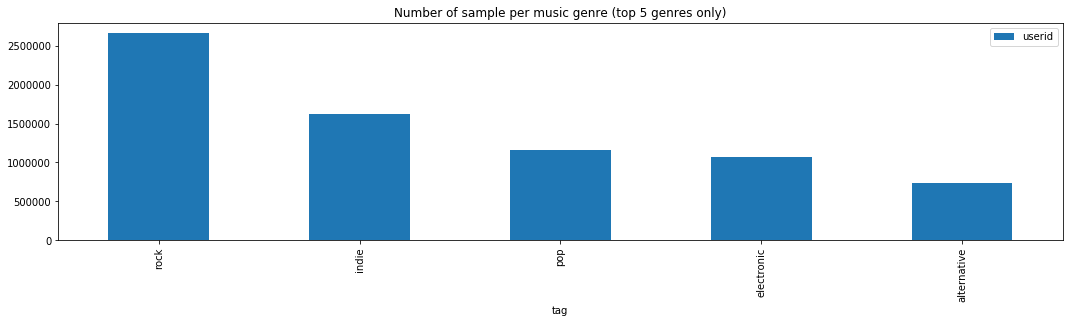

In [49]:
listeningsWithTags.groupby('tag').count()[['userid']].sort_values('userid',ascending=False)\
    .plot.bar(y='userid',figsize=(18,4),title='Number of sample per music genre (top 5 genres only)')

## Release years of the songs
The dataset provides release years of part of the songs.

Link: http://millionsongdataset.com/sites/default/files/AdditionalFiles/tracks_per_year.txt

In [50]:
songYears = pd.read_csv('tracks_per_year.txt',sep='<SEP>',header= None, engine='python',
                         names=['year','tid','artname','traname'])
songYears.head()

,year,tid,artname,traname
0,1922,TRSGHLU128F421DF83,Alberta Hunter,Don't Pan Me
1,1922,TRMYDFV128F42511FC,Barrington Levy,Warm And Sunny Day
2,1922,TRRAHXQ128F42511FF,Barrington Levy,Looking My Love
3,1922,TRFAFTK12903CC77B8,Barrington Levy,Warm And Sunny Day
4,1922,TRSTBUY128F4251203,Barrington Levy,Mandela You're Free


In [51]:
songYears.isnull().sum()

year       0
tid        0
artname    0
traname    0
dtype: int64

In [52]:
songYears.shape

(515576, 4)

In [53]:
# in this case we would get the same join results with using artname and traname on the orginal listenings df
listeningsWithYears = listeningsWithTid.drop(['artname','traname'],axis=1).merge(songYears,on=['tid'])
listeningsWithYears.head()

,userid,timestamp,artid,traid,tid,year,artname,traname
0,user_000001,2009-04-29 14:53:37+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,6bb694b1-0d23-46e9-a03f-03a9e1628a38,TRVLQLN128F933DFE8,2008,Sneaky Sound System,When We Were Young
1,user_000001,2009-04-29 14:12:21+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,6bb694b1-0d23-46e9-a03f-03a9e1628a38,TRVLQLN128F933DFE8,2008,Sneaky Sound System,When We Were Young
2,user_000001,2009-04-29 13:20:51+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,6bb694b1-0d23-46e9-a03f-03a9e1628a38,TRVLQLN128F933DFE8,2008,Sneaky Sound System,When We Were Young
3,user_000001,2009-04-23 14:27:52+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,6bb694b1-0d23-46e9-a03f-03a9e1628a38,TRVLQLN128F933DFE8,2008,Sneaky Sound System,When We Were Young
4,user_000001,2009-04-22 13:48:50+00:00,495fe320-091e-43eb-9321-54a20e7c3f98,6bb694b1-0d23-46e9-a03f-03a9e1628a38,TRVLQLN128F933DFE8,2008,Sneaky Sound System,When We Were Young


We can see we unfortunately loose a bit part of the data:

In [54]:
listenings.shape

(18904597, 6)

In [55]:
listeningsWithYears.shape

(7367239, 8)

# Store the preprocessed data in csv files

In [56]:
# drop ids which we will not use later
listenings.drop(['artid','traid'],axis=1).to_csv('preprocessed_data/listenings.csv',index=False)

In [57]:
# users are a perfect join so we can use the csv even if we don't need the user info
listeningsWithYears.merge(users).drop(['artid','traid','tid','registered','age'],axis=1).to_csv('preprocessed_data/listenings_with_years_and_users.csv',index=False)

In [58]:
# users are a perfect join
listeningsWithTagsAndYears = listeningsWithTags.drop(['artid','traid','val','rn','artname','traname'],axis=1).merge(songYears,on=['tid'])
listeningsWithTagsAndYears.head()

,userid,timestamp,tid,tag,year,artname,traname
0,user_000001,2009-04-29 14:53:37+00:00,TRVLQLN128F933DFE8,alternative,2008,Sneaky Sound System,When We Were Young
1,user_000001,2009-04-29 14:12:21+00:00,TRVLQLN128F933DFE8,alternative,2008,Sneaky Sound System,When We Were Young
2,user_000001,2009-04-29 13:20:51+00:00,TRVLQLN128F933DFE8,alternative,2008,Sneaky Sound System,When We Were Young
3,user_000001,2009-04-23 14:27:52+00:00,TRVLQLN128F933DFE8,alternative,2008,Sneaky Sound System,When We Were Young
4,user_000001,2009-04-22 13:48:50+00:00,TRVLQLN128F933DFE8,alternative,2008,Sneaky Sound System,When We Were Young


We loose some data in the join:

In [59]:
listeningsWithTagsAndYears.shape

(6626003, 7)

In [60]:
listeningsWithTags.shape

(7256963, 10)

In [61]:
listeningsWithTagsAndYears.to_csv('preprocessed_data/listenings_with_years_and_tags.csv',index=False)